In [172]:
import matplotlib as plt
import numpy as np
from numpy import pi
from qiskit import *
import math
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [173]:
def swap_qubits(circuit, num_qubits) :
    for qubit in range(num_qubits // 2):
        circuit.swap(qubit, num_qubits - qubit - 1)

def qft(circuit, qubit_start, qubit_end) :
    # apply hadamard gate
    circuit.h(qubit_start)

    for qubit in range(qubit_start + 1, qubit_end + 1) :
        # apply controlled phase rotation gate
        circuit.cp(pi / 2**(qubit), qubit, qubit_start)

    qubit_start += 1

    # after applying rotations to n qubit, contine with the next qubit
    if qubit_start < qubit_end :
        qft(circuit, qubit_start, qubit_end)
    else :
        circuit.h(qubit_start)

def qft_dagger(circuit, qubit_start, qubit_end) :
    for qubit in range(qubit_end, qubit_start, -1) :
        if qubit != qubit_start :
            # apply controlled phase rotation gate
            print(qubit)
            circuit.cp(- pi / 2**(qubit), qubit, qubit_start)

    # after applying rotations to n qubit, contine with the next qubit
    if qubit_start < qubit_end :
        circuit.h(qubit_start)
        qubit_start += 1
        qft_dagger(circuit, qubit_start, qubit_end)
    else :
        circuit.h(qubit_start)


def rotation(circuit, phase, control_qubit, target_qubit): 
    circuit.cp(2 * pi / 2**(phase), control_qubit, target_qubit)

def working_draper_adder_4_bit_numbers(circuit, num_qubits) :
    rotation(circuit, 1, 0, 7)

    circuit.barrier()

    rotation(circuit, 1, 1, 6)
    rotation(circuit, 2, 0, 6)

    circuit.barrier()

    rotation(circuit, 1, 2, 5)
    rotation(circuit, 2, 1, 5)
    rotation(circuit, 3, 0, 5)

    circuit.barrier()

    rotation(circuit, 1, 3, 4)
    rotation(circuit, 2, 2, 4)
    rotation(circuit, 3, 1, 4)
    rotation(circuit, 4, 0, 4)

def draper_adder(circuit, num_qubits) :
    for target_qubit in range(num_qubits - 1, num_qubits // 2 - 1, -1) :
        phase_index = 1
        for control_qubit in range(num_qubits -1 - target_qubit, -1, -1) :
            rotation(circuit, phase_index, control_qubit, target_qubit)
            phase_index += 1
        
        circuit.barrier()

def draper_adder_gate(num_qubits) :
    circuit = QuantumCircuit(num_qubits)

    for target_qubit in range(num_qubits - 1, num_qubits // 2 - 1, -1) :
        phase_index = 1
        for control_qubit in range(num_qubits -1 - target_qubit, -1, -1) :
            rotation(circuit, phase_index, control_qubit, target_qubit)
            phase_index += 1

    return circuit

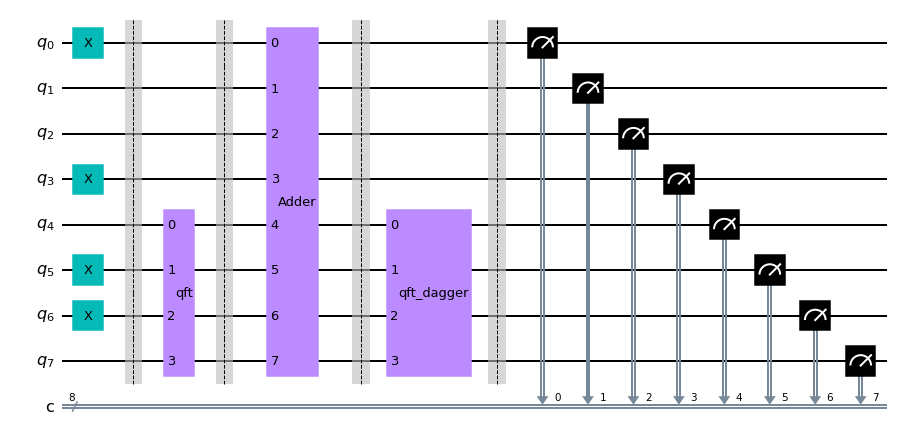

In [174]:
circuit = QuantumCircuit(8, 8)

# first number will be 1010 and second 0101 which should be added to 1111
circuit.x([0, 3])
circuit.x([5, 6])

circuit.barrier()

circuit.compose(QFT(4, do_swaps = True, name = 'qft'), qubits = [4, 5, 6, 7], inplace = True)

circuit.barrier()

# binary fraction addition of the two numbers, with the help of controlled phase gates
# draper_adder(circuit, 8)
circuit.compose(draper_adder_gate(8).to_gate(label='Adder'), inplace = True)

circuit.barrier()

circuit.compose(QFT(4, do_swaps = True, inverse=True, name='qft_dagger'), qubits = [4, 5, 6, 7], inplace = True)

circuit.barrier()

circuit.measure([0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7])

circuit.draw('mpl')

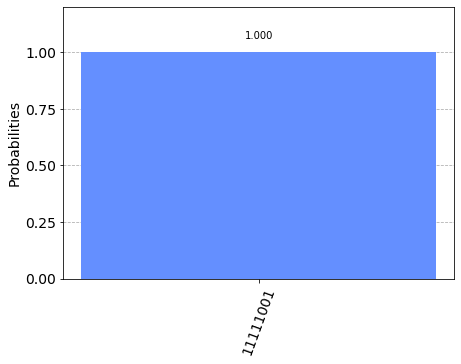

In [175]:

# simulate the circuit
simulator = simulator = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend = simulator, shots = 1000).result()

counts = result.get_counts()

plot_histogram(counts)